In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

In [294]:
# Load in Data
sqrl = pd.read_csv('2018_Central_Park_Squirrel_Census.csv')
# Create dataset for predicting Behavior based on Location
data = pd.DataFrame()
# If Squirrel is on the ground its 0, if theyre above the around its 1
data['Location'] = sqrl['Location']
data[data['Location'] == 'Above Ground'] = 1
data[data['Location'] == 'Ground Plane'] = 0
for col in sqrl.columns:
    if isinstance(sqrl[col][0], np.bool_):
        # Modify Columns so Booloan False = 0 and Booloan True = 1
        data[col] = sqrl[col].astype(int)
# Remove NA rows
data = data.dropna(ignore_index =True)
# Remove climbing row
data = data.drop('Climbing', axis=1)
data = data.drop('Foraging', axis=1)
data = data.drop('Approaches', axis=1)
# Move data towards a 50/50 split between Ground and Tree
even_data = pd.concat([data, data[data['Location'] == 1]], ignore_index=True)

### Variable Investigation

In [157]:
changed = []
test = sqrl.copy()
for col in sqrl.columns[:-1]:
    if isinstance(sqrl[col].dropna(ignore_index=True)[0], str):
        changed.append(col)
        values = sqrl[col].unique().astype(str)
        for i in range(len(sqrl)):
            test.loc[i, col] = np.where(values == str(sqrl.loc[i, col]))[0][0]
test['Location'] = sqrl['Location']

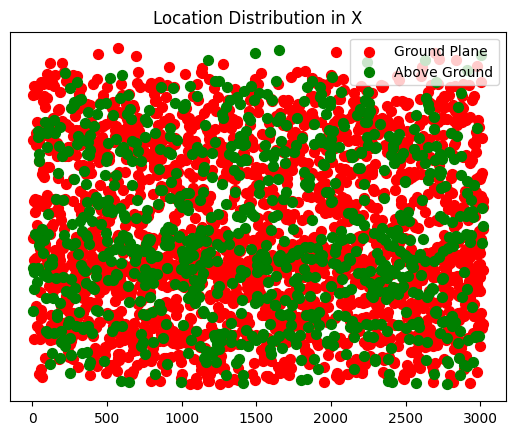

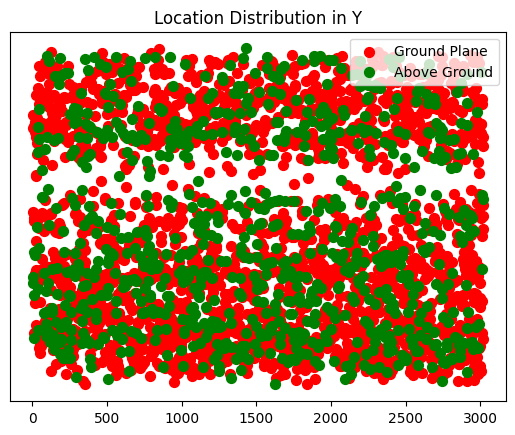

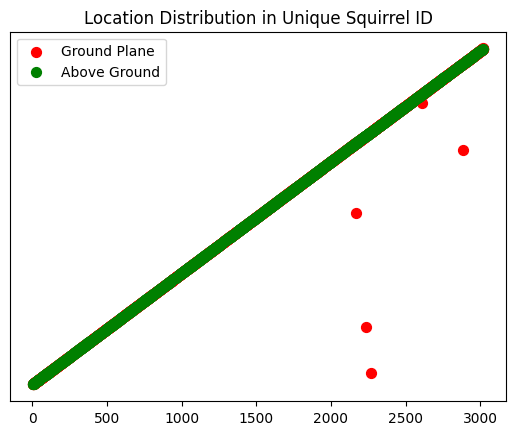

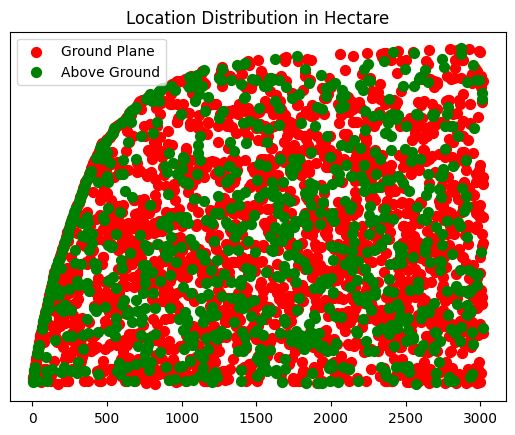

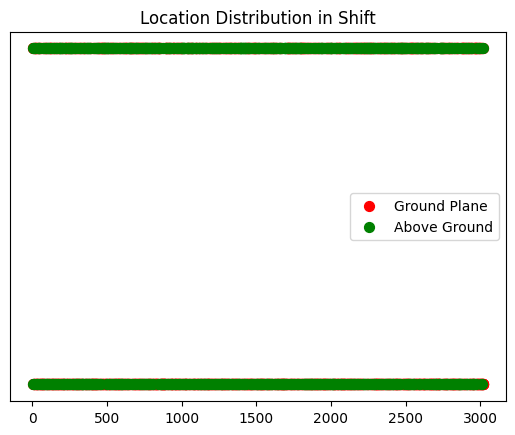

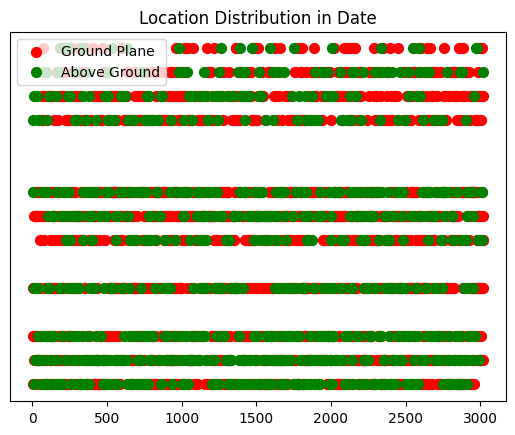

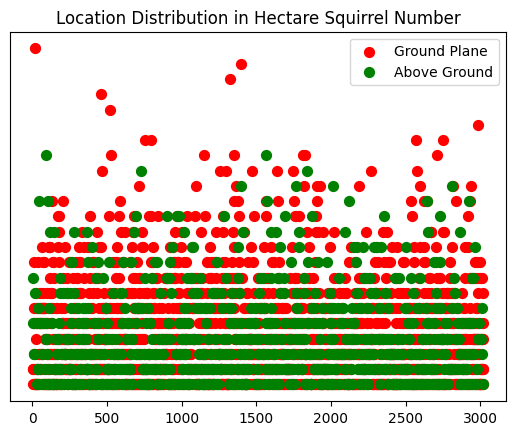

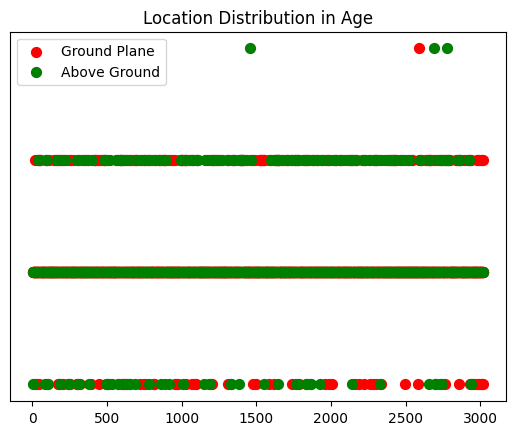

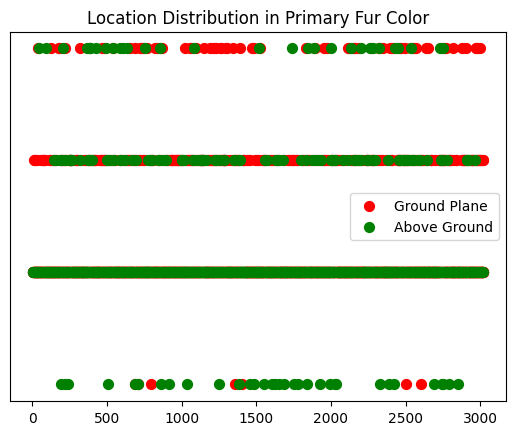

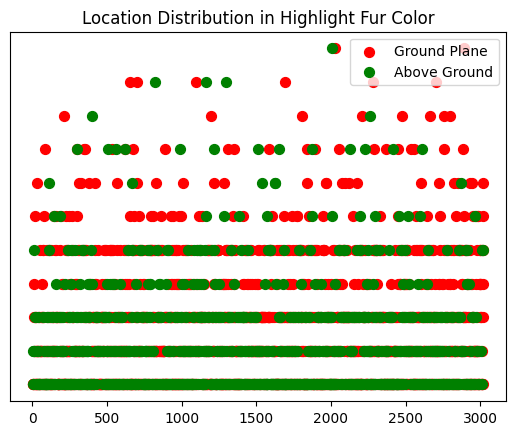

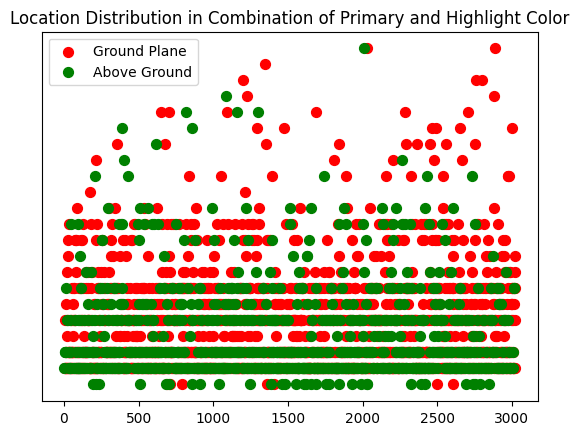

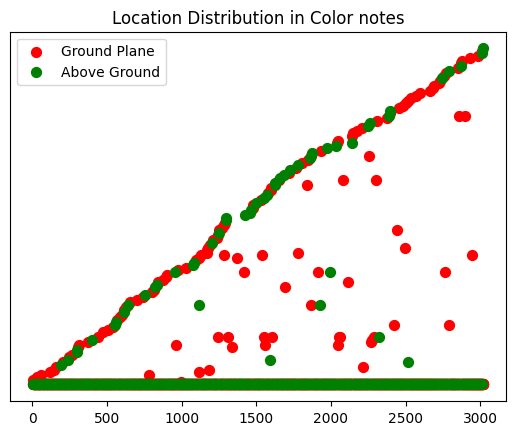

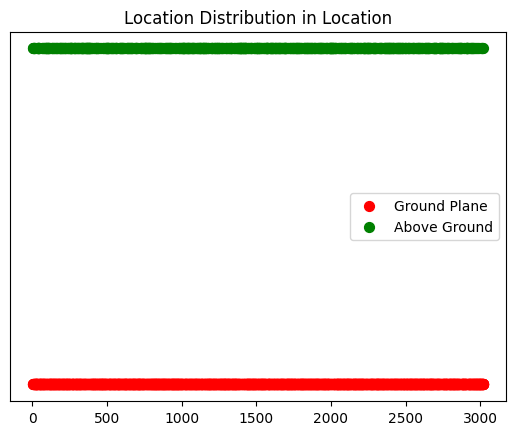

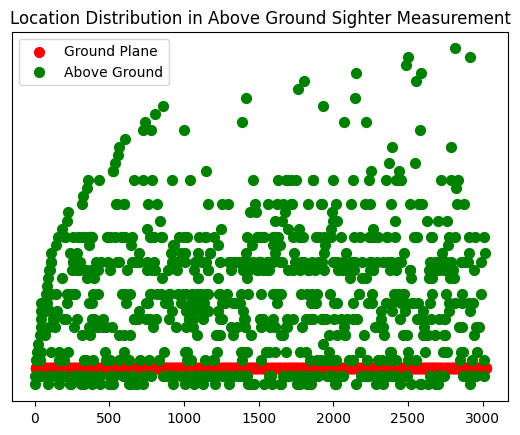

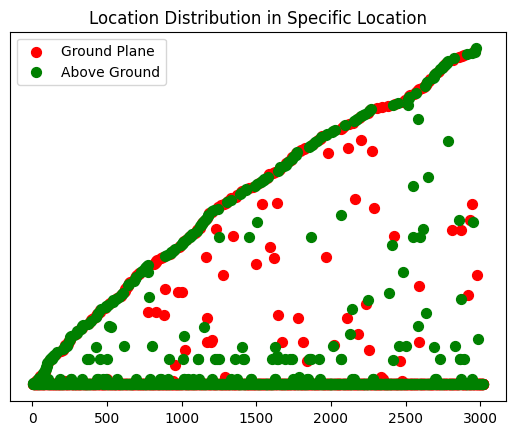

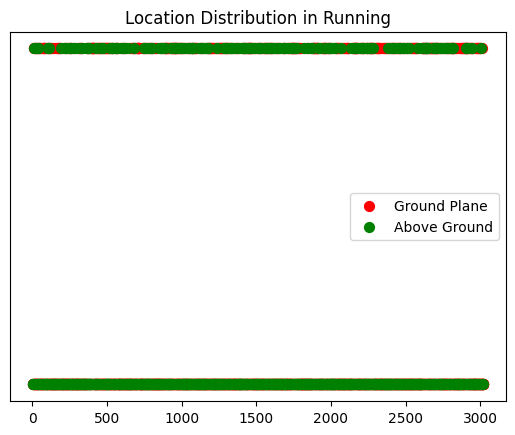

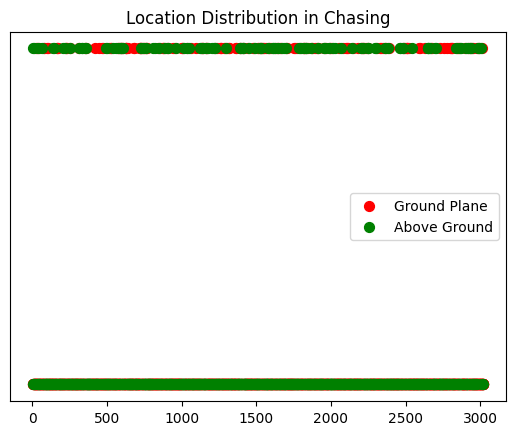

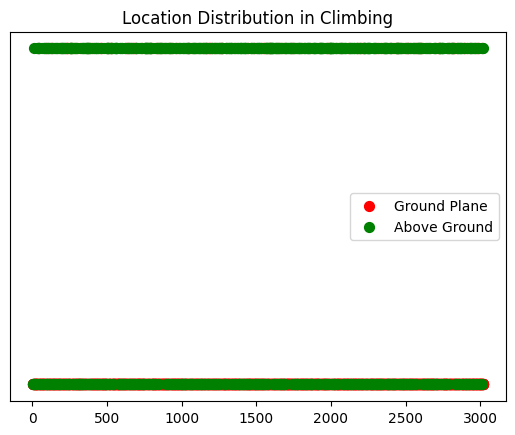

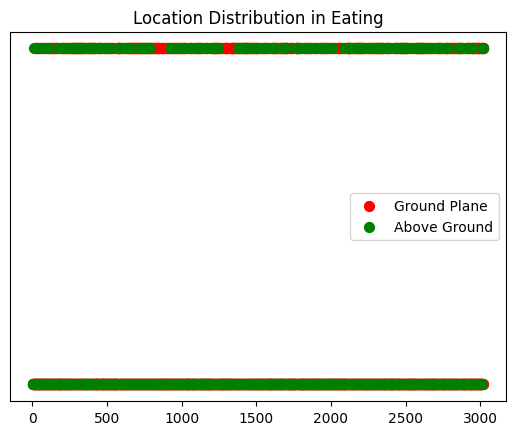

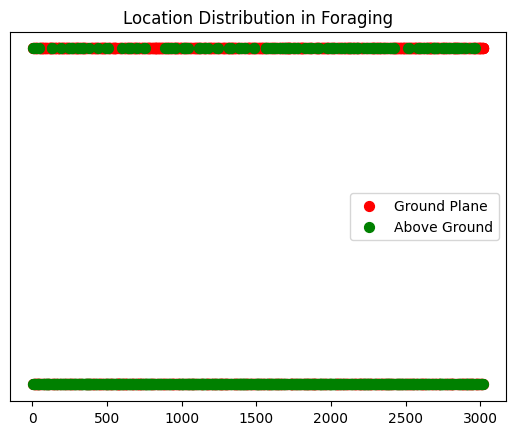

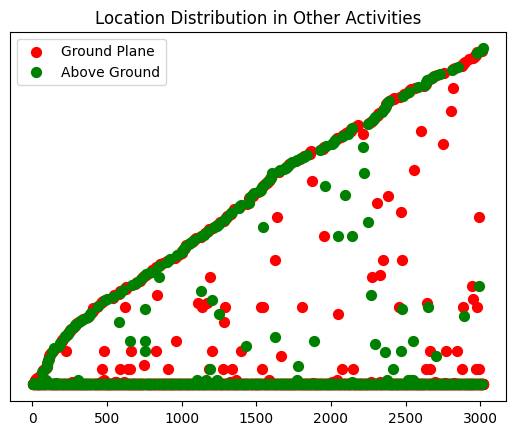

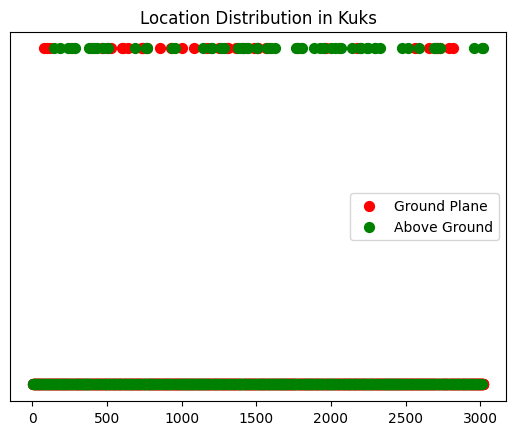

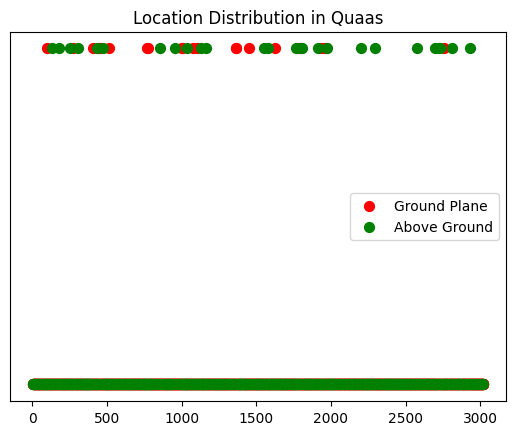

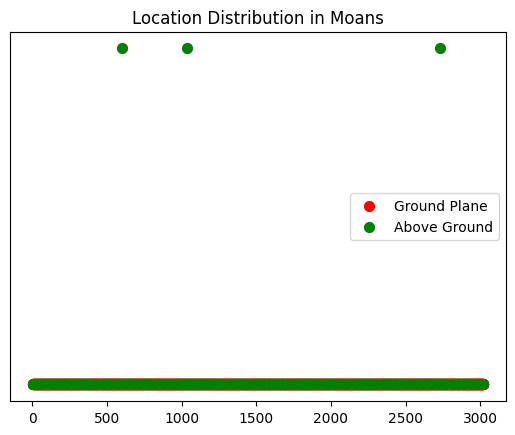

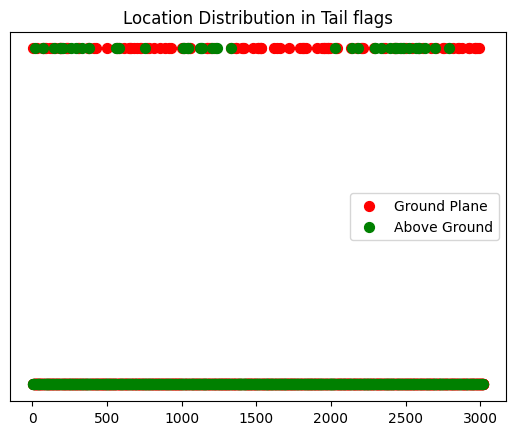

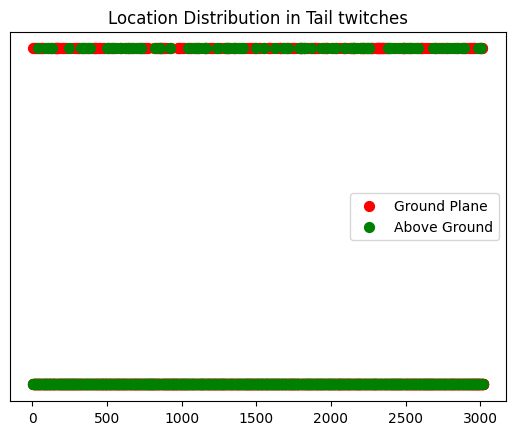

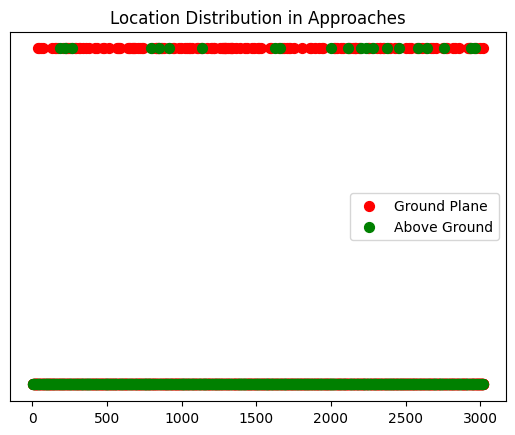

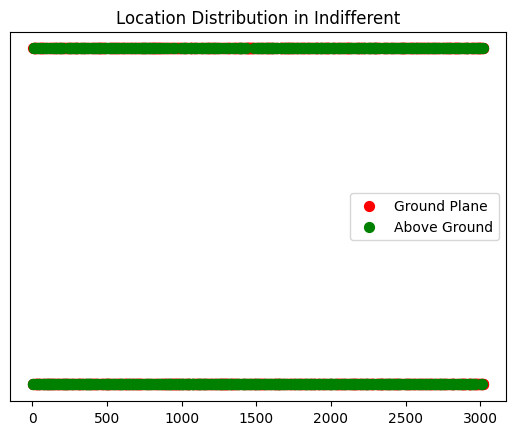

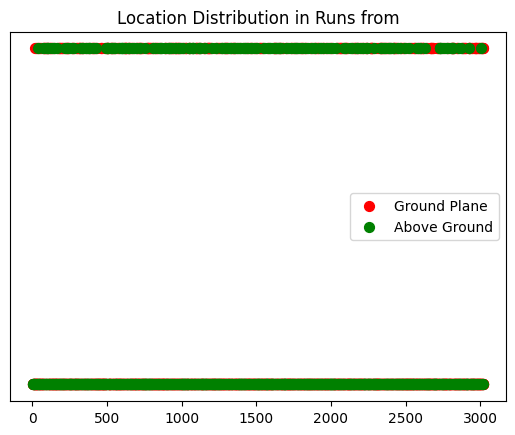

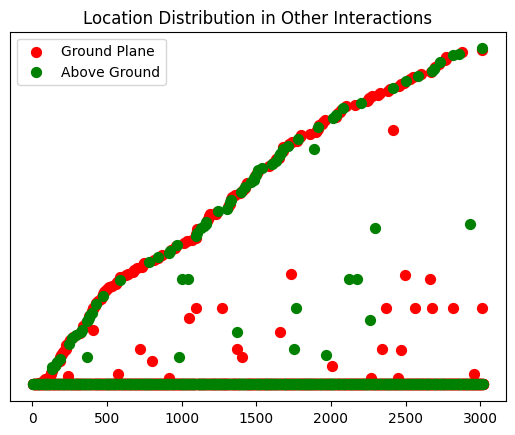

In [160]:
targets = ['Ground Plane','Above Ground']
colors = ['r', 'g']
for col in test.columns[:-1]:
    for target, color in zip(targets,colors):
        indicesToKeep = test['Location'] == target
        plt.scatter(test.loc[indicesToKeep].index
                , test.loc[indicesToKeep, col]
                , c = color
                , s = 50)
    plt.legend(targets)
    plt.yticks([])
    plt.title(f'Location Distribution in {col}')
    plt.show()

### PCA

In [226]:
# Scale first
x = pd.DataFrame(StandardScaler().fit_transform(data),columns=data.columns)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_
# Make it into a dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data[['Location']]], axis = 1)


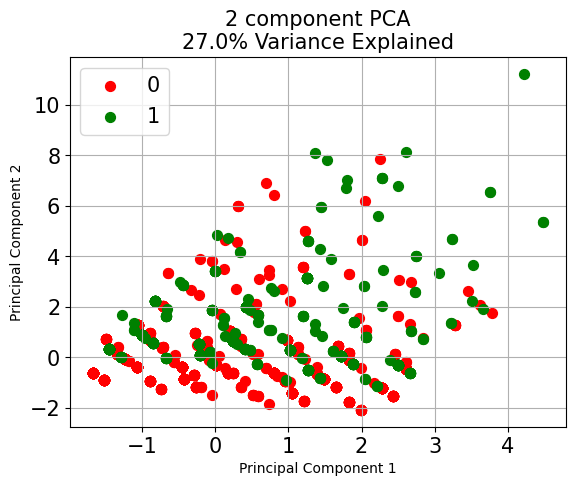

In [227]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2 component PCA\n{:.1f}% Variance Explained'.format(sum(explained_variance)*100), fontsize = 15)

targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Location'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

[pca] >Extracting column labels from dataframe.
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.


[scatterd] >INFO> Create scatterplot


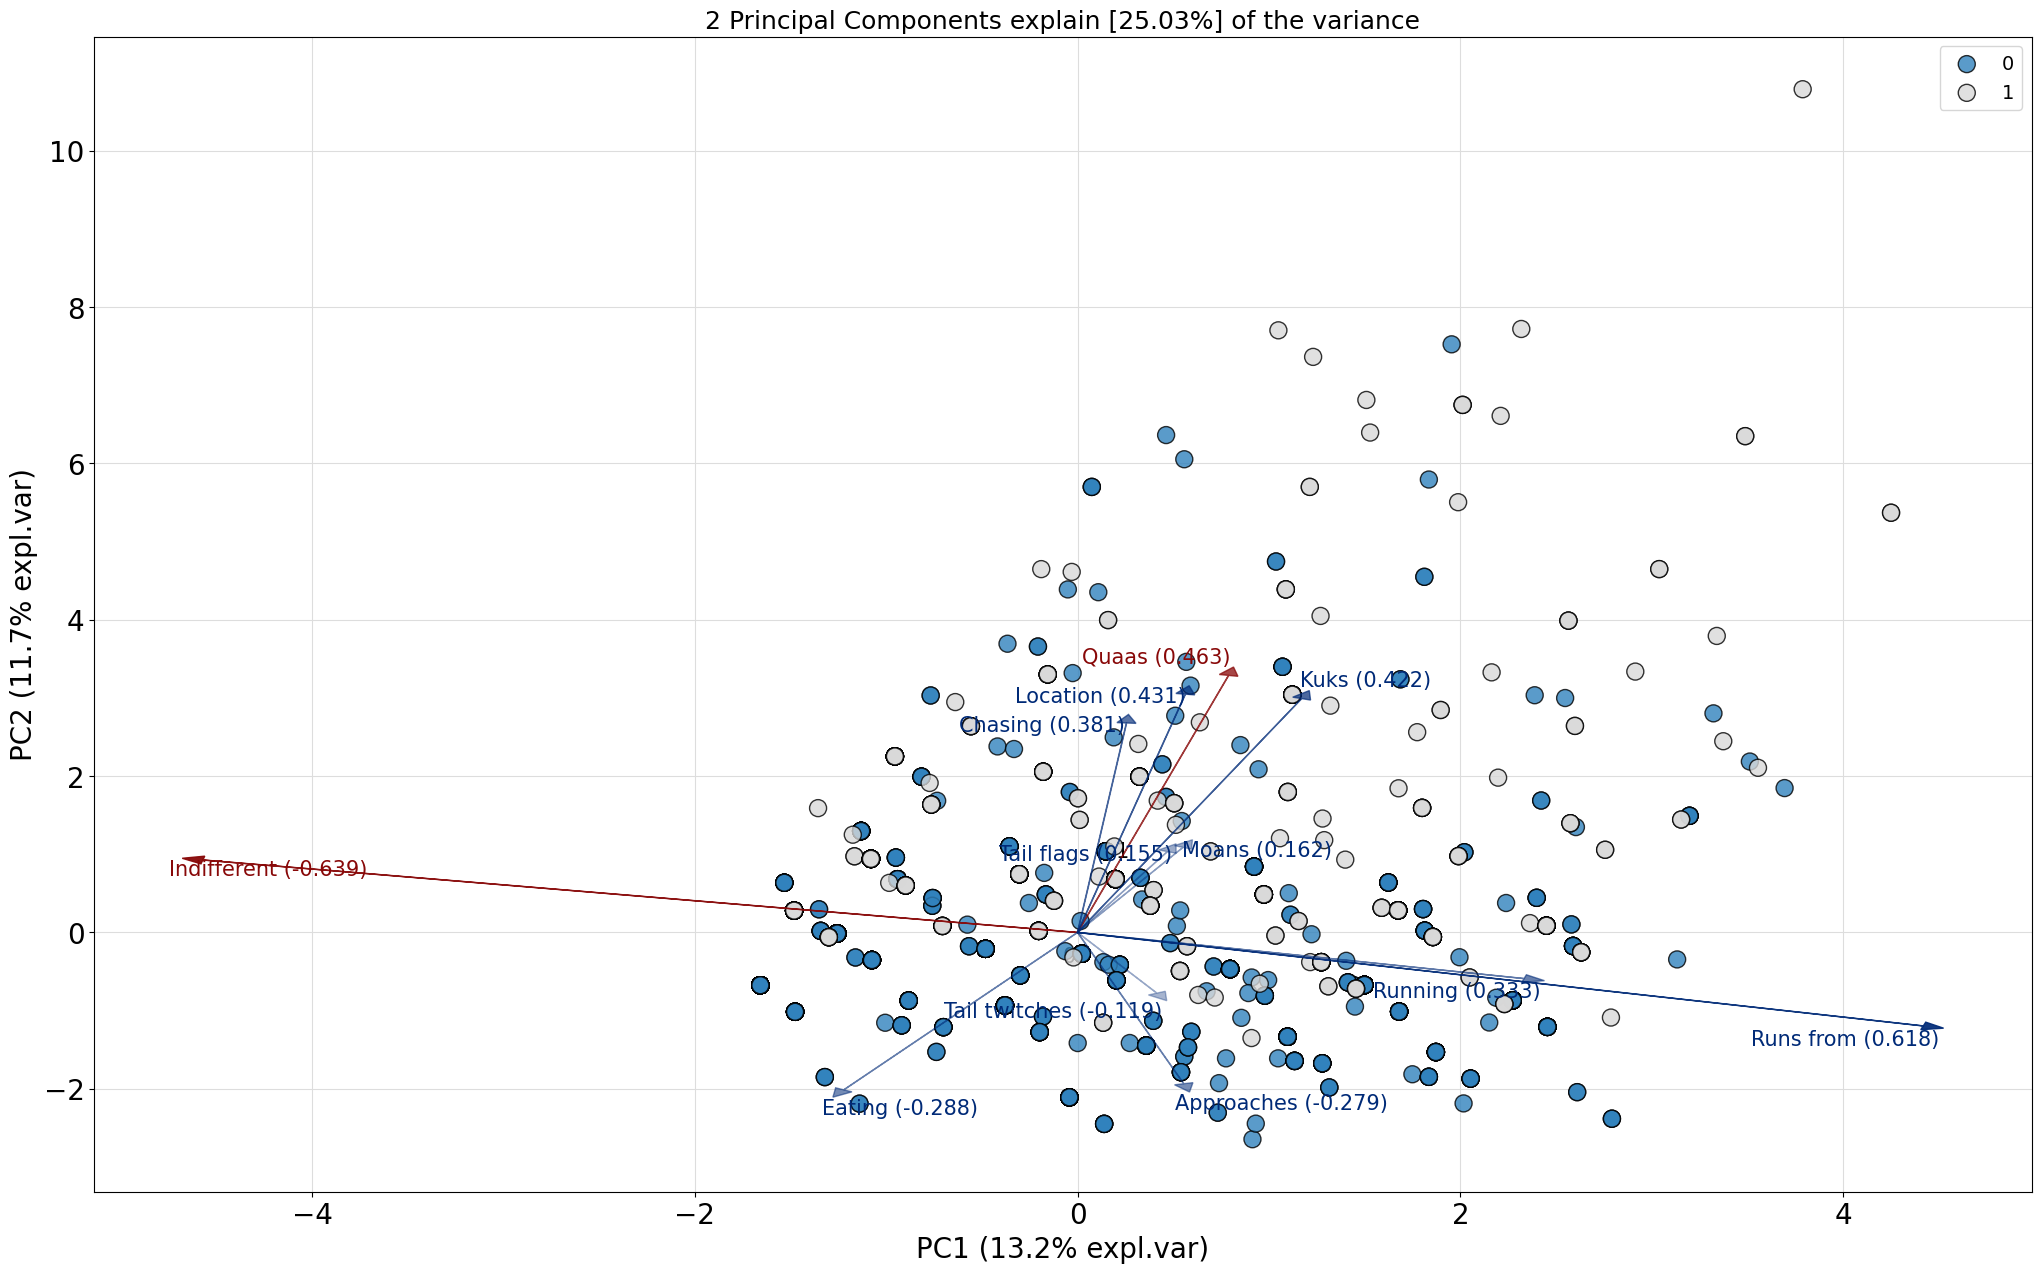

In [175]:
from pca import pca

# BiPlot
model = pca(n_components=2)
# Fit and transform
results = model.fit_transform(X=x, row_labels=data['Location'])

# Create a biplot
fig, ax = model.biplot(fontsize=15)

Text(0, 0.5, 'Variance Explained')

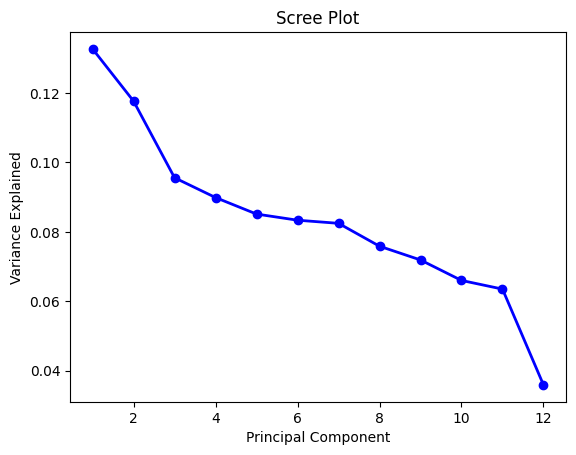

In [170]:
# Scree Plot

pca = PCA(n_components=len(x.columns))
principalComponents = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
#plt.axvline(x=2, color = 'r', linestyle = '-.')

### Decision Tree

In [295]:
X_train, X_test, y_train, y_test = train_test_split(
        data.iloc[:,1:], data['Location'], test_size=0.4, random_state=100)

y_test = y_test.astype('int')
y_train = y_train.astype('int')

0


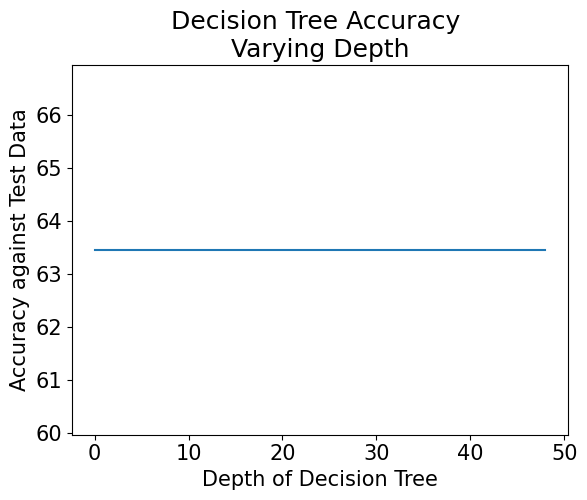

In [275]:
acc = []
for depth in range(1,50):
        # Initialize Model
        clf_entropy = DecisionTreeClassifier(
                criterion="entropy", random_state=100,
                max_depth=10, min_samples_leaf=5)

        # Performing training
        clf_entropy.fit(X_train, y_train)
        y_pred = clf_entropy.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred)*100)
fig = plt.figure()
plt.plot(acc)
plt.title('Decision Tree Accuracy \nVarying Depth')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy against Test Data')
print(np.where(acc == max(acc))[0][0])

In [296]:
# Initialize Model
clf_entropy = DecisionTreeClassifier(
        criterion="entropy", random_state=100,
        max_depth=10, min_samples_leaf=5)

# Performing training
clf_entropy.fit(X_train, y_train)
y_pred = clf_entropy.predict(X_test)
accuracy_score(y_test, y_pred)*100

63.57659434582511

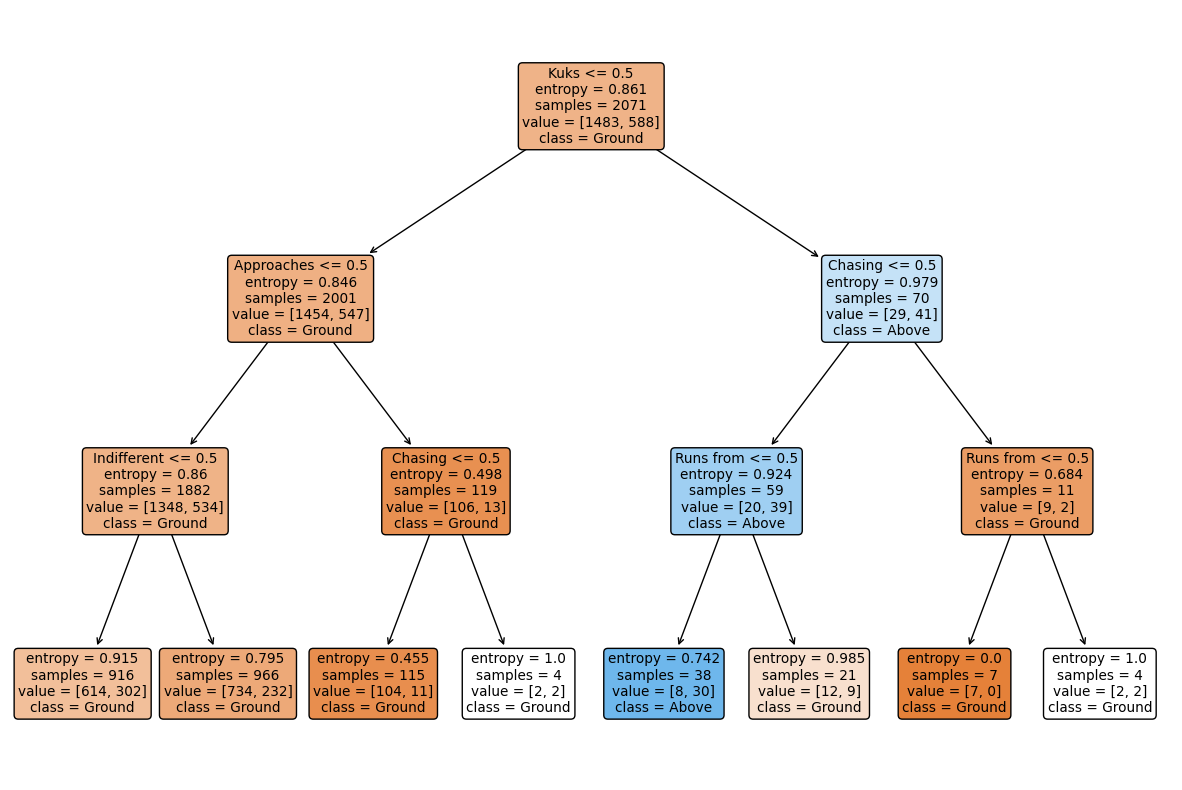

In [249]:
plt.figure(figsize=(15, 10))
plot_tree(clf_entropy, filled=True, feature_names=X_train.columns, class_names=['Ground', 'Tree'], rounded=True)
plt.show()

In [297]:
confusion_matrix(y_test, y_pred)

array([[708, 141],
       [413, 259]], dtype=int64)

### Random Forest

In [304]:
rf = RandomForestClassifier(max_depth=10, n_estimators=2000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6370808678500987

In [305]:
confusion_matrix(y_test, y_pred)

array([[700, 149],
       [403, 269]], dtype=int64)

### SVC

In [306]:
model=SVC(C=100,gamma='auto',kernel='rbf')
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
accuracy_score(y_test,y_pred)

0.6298487836949376

In [307]:
confusion_matrix(y_test, y_pred)

array([[700, 149],
       [414, 258]], dtype=int64)